# **MSC 7208 Data Mining Project - Amazon Reviews Analysis with MapReduce**

## 1. Setup and Preparation

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')
file_path = "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"
results_path = '/content/drive/My Drive/MSC/MSC-II/Data Mining/results'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Install Mrjob
!pip install --quiet mrjob

In [ ]:
!head -6  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"

{"rating": 5.0, "title": "Best value for the money", "text": "These masks are great even though there is no 'inside' or 'outside' to let you know whether the mask is inside out or not. They do the job and I've ordered these a couple of times now without hesitation.", "images": [], "asin": "B08C7HDF1F", "parent_asin": "B0BX2672L8", "user_id": "AG2L7H23R5LLKDKLBEF2Q3L2MVDA", "timestamp": 1676602453163, "helpful_vote": 3, "verified_purchase": true}
{"rating": 5.0, "title": "TOO good.", "text": "These scissors are so good they got stolen by one of the home care aides. Really super sharp and sturdy scissors which I have no choice but to have to order again.", "images": [], "asin": "B07BT4YLHT", "parent_asin": "B07BT4YLHT", "user_id": "AG2L7H23R5LLKDKLBEF2Q3L2MVDA", "timestamp": 1671844170434, "helpful_vote": 1, "verified_purchase": true}
{"rating": 4.0, "title": "Good", "text": "Good. Sensor push easier to work with but these are more reliable", "images": [], "asin": "B06XY65HCX", "parent_a

### Reed file in chunks of 10,000 lines, memory effeciency

In [ ]:
# Reed file in chunks of 10,000 lines, memory effeciency
chunk_size = 10_000
chunks = pd.read_json(file_path, lines=True, chunksize=chunk_size)

df = pd.concat(chunks)  # Combine all chunks into one DataFrame

### Exploratry Data Analysis (EDA)


In [ ]:
df.shape

(5183005, 10)

In [ ]:
df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Best value for the money,These masks are great even though there is no ...,[],B08C7HDF1F,B0BX2672L8,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,2023-02-17 02:54:13.163,3,True
1,5,TOO good.,These scissors are so good they got stolen by ...,[],B07BT4YLHT,B07BT4YLHT,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,2022-12-24 01:09:30.434,1,True
2,4,Good,Good. Sensor push easier to work with but thes...,[],B06XY65HCX,B06XY65HCX,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-01-21 19:54:56.378,0,True
3,5,Five Stars,Great ORB finish & size. Bought for our laundr...,[],B01KW20EQ0,B01KW20EQ0,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,2018-07-02 18:39:44.971,0,True
4,1,Only one ply - will not work,These masks are notably thinner than other dis...,[],B08F59NF33,B08N66L183,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2022-01-30 14:50:43.612,0,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5183005 entries, 0 to 5183004
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int64         
 1   title              object        
 2   text               object        
 3   images             object        
 4   asin               object        
 5   parent_asin        object        
 6   user_id            object        
 7   timestamp          datetime64[ns]
 8   helpful_vote       int64         
 9   verified_purchase  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 360.8+ MB


In [ ]:
print("\nMissing Values by Column:")
print(df.isnull().sum())


Missing Values by Column:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


In [ ]:
# Identify object columns (excluding bool/datetime)
object_cols = df.select_dtypes(include=['object']).columns

# Convert to string dtype (memory efficient)
df[object_cols] = df[object_cols].astype('string')  # Pandas' StringDtype (not Python str)

df.dtypes

,0
rating,int64
title,string[python]
text,string[python]
images,string[python]
asin,string[python]
parent_asin,string[python]
user_id,string[python]
timestamp,datetime64[ns]
helpful_vote,int64
verified_purchase,bool


Distribution of Rattings

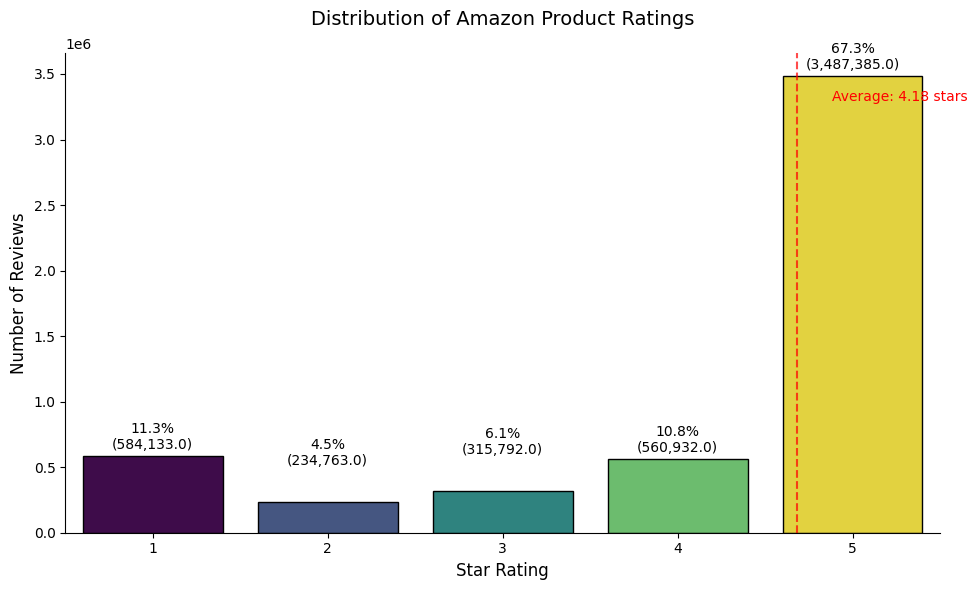

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='rating', data=df,
                   hue='rating',  # Assign to hue
                   palette='viridis',
                   edgecolor='black',
                   legend=False)  # Disable redundant legend

plt.title("Distribution of Amazon Product Ratings", fontsize=14, pad=20)
plt.xlabel("Star Rating", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
sns.despine()

total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height/total
    y_pos = height + 0.05*total
    va = 'bottom' if height < 0.1*total else 'top'
    ax.text(p.get_x() + p.get_width()/2.,
            y_pos,
            f'{percentage:.1f}%\n({height:,})',
            ha='center',
            va=va,
            fontsize=10)

# Add average rating line (unchanged)
avg_rating = df['rating'].mean()
plt.axvline(avg_rating - 0.5, color='red', linestyle='--', alpha=0.7)
plt.text(avg_rating - 0.3, ax.get_ylim()[1]*0.9,
         f'Average: {avg_rating:.2f} stars',
         color='red')

plt.tight_layout()
plt.show()

visualization for verified vs. unverified purchase ratings

Text(0.5, 1.0, 'Verified vs Unverified Purchases by Rating')

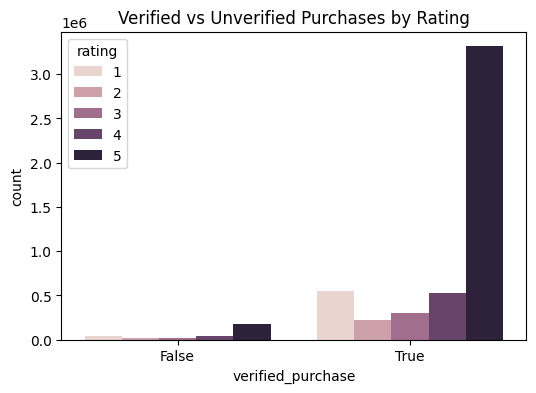

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='verified_purchase', data=df, hue='rating')
plt.title("Verified vs Unverified Purchases by Rating")

In [ ]:
print("\nKey Statistics:")
print(df[['rating', 'helpful_vote']].describe())


Key Statistics:
             rating  helpful_vote
count  5.183005e+06  5.183005e+06
mean   4.183227e+00  9.320352e-01
std    1.376844e+00  9.970753e+00
min    1.000000e+00 -1.000000e+00
25%    4.000000e+00  0.000000e+00
50%    5.000000e+00  0.000000e+00
75%    5.000000e+00  0.000000e+00
max    5.000000e+00  5.611000e+03


## 2. Count the Number of Reviews per Product

### (a) Write a MapReduce job that maps each review to its product ID.

### (b) Reduce by counting the total number of reviews for each product.

**Mapper Phase:**
- Parses each JSON line from the input file
- Extracts the `asin` (Amazon Standard Identification Number)
- Emits `(product_id, 1)` pairs

**Reducer Phase:**
- Receives all `(product_id, [1, 1, ...])` pairs
- Sums the counts to get total reviews per product
- Emits final `(product_id, total_reviews)` pairs

In [ ]:
%%file review_to_produuct_id.py

from mrjob.job import MRJob
import json

class ProductReviewMapper(MRJob):

    def mapper(self, _, line):
        try:
            review = json.loads(line)
            asin = review.get('asin', 'UNKNOWN')  # Product ID
            yield asin, 1  # Emit (product_id, 1)

        except json.JSONDecodeError:
            # Skip malformed lines
            pass

    def reducer(self, asin, counts):
        yield asin, sum(counts)  # Sum reviews per product

if __name__ == '__main__':
    ProductReviewMapper.run()

Writing review_to_produuct_id.py


In [ ]:
!python review_to_produuct_id.py  '/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl' --output-dir  '/content/drive/My Drive/MSC/MSC-II/Data Mining/results/review_to_produuct_id'

No configs found; falling back on auto-configuration
No configs specified for inline runner
Running step 1 of 1...
Creating temp directory /tmp/review_to_produuct_id.root.20250417.223515.181418
job output is in /content/drive/My Drive/MSC/MSC-II/Data Mining/results/review_to_produuct_id
Removing temp directory /tmp/review_to_produuct_id.root.20250417.223515.181418...


## 3. Compute the Average Star Rating for Each Product



### (a) Write a MapReduce job to calculate the average star rating per product.

### (b) Demonstrate your ability to aggregate numerical data across the dataset.

**Mapper Phase**
- Extracts `(product_id, (rating, 1))` pairs from each review
- Handles data validation:
  - Skips malformed JSON entries
  - Filters out invalid ratings (ensures ratings are within valid range)

**Combiner Phase (Optimization)**
- Performs local aggregation before shuffling:
  - Sums ratings for each product per mapper
  - Counts number of reviews per product per mapper
- Benefits:
  - Significantly reduces network traffic
  - Improves performance through partial aggregation

**Reducer Phase**
- Receives aggregated values for each product:
  - Total sum of all ratings
  - Total count of all reviews
- Computes final average using:
  ```python
  average_rating = total_ratings_sum / total_reviews_count

In [ ]:
%%file average_rating_per_product.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import json

class AverageProductRating(MRJob):

    def mapper_extract_ratings(self, _, line):
        """Mapper: Extract product ID and rating"""
        try:
            review = json.loads(line)
            asin = review.get('asin', 'UNKNOWN')
            rating = float(review.get('rating', 0))
            yield asin, (rating, 1)  # Emit (product_id, (rating, 1))
        except (json.JSONDecodeError, ValueError):
            pass

    def reducer_combine_ratings(self, asin, rating_counts):
        """Combiner: Local aggregation to reduce network traffic"""
        total_rating = 0
        total_reviews = 0

        for rating, count in rating_counts:
            total_rating += rating
            total_reviews += count

        yield asin, (total_rating, total_reviews)

    def reducer_calculate_avg(self, asin, rating_sums):
        """Reducer: Final average calculation"""
        for total_rating, total_reviews in rating_sums:
            yield asin, round(total_rating / total_reviews, 2)

    def steps(self):
        return [
            MRStep(mapper=self.mapper_extract_ratings,
                   combiner=self.reducer_combine_ratings,
                   reducer=self.reducer_calculate_avg)
        ]

if __name__ == '__main__':
    AverageProductRating.run()

Writing average_rating_per_product.py


In [ ]:
!python average_rating_per_product.py  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"

Streaming output truncated to the last 5000 lines.
"B0723F1VJY"	2.0
"B0723F1VJY"	3.0
"B0723F1VJY"	5.0
"B0723F28G2"	5.0
"B0723F28G2"	5.0
"B0723F5BJV"	5.0
"B0723F68FR"	5.0
"B0723F68FR"	2.67
"B0723F68FR"	5.0
"B0723FXWM1"	2.0
"B0723GNC9N"	5.0
"B0723GNC9N"	2.0
"B0723GNY5P"	5.0
"B0723GNY5P"	5.0
"B0723GNY5P"	5.0
"B0723GNY5P"	4.67
"B0723GXF9S"	5.0
"B0723GXF9S"	5.0
"B0723GXH9F"	3.0
"B0723H1CP7"	5.0
"B0723H1CP7"	3.0
"B0723H1CP7"	5.0
"B0723HJ9KX"	4.07
"B0723HJ9KX"	4.17
"B0723HJ9KX"	5.0
"B0723HJ9KX"	4.48
"B0724YT77Z"	1.0
"B0724YX6CL"	5.0
"B0724Z2HQQ"	1.0
"B0724Z2HQQ"	5.0
"B0724Z2HQQ"	1.0
"B0724Z5XP8"	5.0
"B0724Z5XP8"	5.0
"B0724Z5XP8"	5.0
"B0724Z7RBJ"	1.0
"B0724ZMKSL"	1.0
"B0724ZNC1N"	4.0
"B0724ZYQJ1"	5.0
"B0724ZYQJ1"	4.0
"B07251MRJJ"	4.0
"B07251MRJJ"	4.0
"B072524GX9"	3.0
"B072524WQR"	5.0
"B072524WQR"	5.0
"B072524WQR"	5.0
"B07252FC2V"	5.0
"B07252QYZM"	3.67
"B07252QYZM"	5.0
"B07252QYZM"	3.0
"B07252Z6QQ"	2.0
"B07252Z6QQ"	5.0
"B072538K2N"	4.62
"B072538K2N"	5.0
"B072538K2N"	4.25
"B072538K2N"	2.8
"B0725

## 4. Identify the Top Ten Most Reviewed Products


### (a) Write a MapReduce job that counts the number of reviews per product.
### (b) Sort the products by their review count and extract the top ten.

**Phase 1: Counting Reviews**

- Mapper emits (product_id, 1) for each review

- Reducer sums counts per product and emits (None, (total, asin)) to prepare for global sorting

**Phase 2: Top-10 Selection**

-Uses a min-heap to efficiently track the 10 highest counts

-Outputs products sorted by review count in descending order

In [ ]:
%%file top_ten_reviewed_products.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json
import heapq

class TopReviewedProducts(MRJob):

    # (a) Count reviews per product
    def mapper_count_reviews(self, _, line):
        try:
            review = json.loads(line)
            yield review.get('asin', 'UNKNOWN'), 1
        except json.JSONDecodeError:
            pass

    def reducer_sum_reviews(self, asin, counts):
        yield None, (sum(counts), asin)  # Emit (None, (count, asin)) for global sort

    # (b) Identify top 10 products
    def reducer_find_top10(self, _, count_asin_pairs):
        top10 = []
        for count, asin in count_asin_pairs:
            if len(top10) < 10:
                heapq.heappush(top10, (count, asin))
            else:
                heapq.heappushpop(top10, (count, asin))

        # Output in descending order
        for count, asin in sorted(top10, reverse=True):
            yield asin, count

    def steps(self):
        return [
            MRStep(mapper=self.mapper_count_reviews,
                   reducer=self.reducer_sum_reviews),
            MRStep(reducer=self.reducer_find_top10)
        ]

if __name__ == '__main__':
    TopReviewedProducts.run()

Writing top_ten_reviewed_products.py


In [ ]:
!python top_ten_reviewed_products.py  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/top_ten_reviewed_products.root.20250417.224441.277123
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/top_ten_reviewed_products.root.20250417.224441.277123/output
Streaming final output from /tmp/top_ten_reviewed_products.root.20250417.224441.277123/output...
"B09KZ6TBNY"	15842
"B000EFDOOA"	14641
"B01NAQD0KD"	9389
"B00837ZGRY"	8284
"B007Q2M17K"	8126
"B078XDFDPY"	7233
"B0016HF5GK"	6595
"B00FKBR1ZG"	6432
"B08C7HDF1F"	6273
"B0787Q54M1"	5897
Removing temp directory /tmp/top_ten_reviewed_products.root.20250417.224441.277123...


## 5. Calculate the Average Helpfulness Score for Reviews

**Mapper Phase:**

- Extracts helpful_vote and unhelpful_vote from each review

- Calculates helpfulness score: helpful_votes / (helpful_votes + unhelpful_votes)

- Emits ("avg_helpfulness", (score, 1)) for reviews with votes

**Reducer Phase:**

- Sums all scores and counts

- Computes global average: total_scores / total_reviews_with_votes

In [ ]:
%%file average_hopefulness_score.py
from mrjob.job import MRJob
import json

class AverageHelpfulnessScore(MRJob):

    def mapper(self, _, line):
        try:
            review = json.loads(line)
            helpful_vote = review.get('helpful_vote', 0)
            total_vote = helpful_vote + review.get('unhelpful_vote', 0)

            # Only calculate if there are votes
            if total_vote > 0:
                score = helpful_vote / total_vote
                yield "avg_helpfulness", (score, 1)  # Key for global average

        except (json.JSONDecodeError, ValueError, ZeroDivisionError):
            pass

    def reducer(self, key, score_counts):
        total_score = 0
        total_reviews = 0

        for score, count in score_counts:
            total_score += score
            total_reviews += count

        yield key, round(total_score / total_reviews, 4)

if __name__ == '__main__':
    AverageHelpfulnessScore.run()

Writing average_hopefulness_score.py


In [ ]:
!python average_hopefulness_score.py  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/average_hopefulness_score.root.20250416.113937.882739
Running step 1 of 1...
job output is in /tmp/average_hopefulness_score.root.20250416.113937.882739/output
Streaming final output from /tmp/average_hopefulness_score.root.20250416.113937.882739/output...
"avg_helpfulness"	1.0
Removing temp directory /tmp/average_hopefulness_score.root.20250416.113937.882739...


## Time-Based Analysis of Ratings

In [ ]:
%%file average_rating_by_time_period.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json
from datetime import datetime

class RatingTrendAnalysis(MRJob):

    def mapper_extract(self, _, line):
        try:
            review = json.loads(line)
            timestamp = review.get('timestamp')
            if timestamp:
                dt = datetime.fromtimestamp(timestamp/1000)  # Convert ms to datetime
                yield (dt.year, dt.month), float(review.get('rating', 0))
        except (json.JSONDecodeError, ValueError):
            pass

    def reducer_aggregate(self, time_period, ratings):
        ratings = list(ratings)
        yield time_period, {
            'avg_rating': round(sum(ratings)/len(ratings), 2),
            'review_count': len(ratings)
        }

    def steps(self):
        return [MRStep(mapper=self.mapper_extract,
                      reducer=self.reducer_aggregate)]

if __name__ == '__main__':
    RatingTrendAnalysis.run()

Overwriting average_rating_by_time_period.py


In [ ]:
!python  average_rating_by_time_period.py  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl" --output-dir  '/content/drive/My Drive/MSC/MSC-II/Data Mining/results/average_rating_by_time_period'

No configs found; falling back on auto-configuration
No configs specified for inline runner
Running step 1 of 1...
Creating temp directory /tmp/average_rating_by_time_period.root.20250417.230915.537665
job output is in /content/drive/My Drive/MSC/MSC-II/Data Mining/results/average_rating_by_time_period
Removing temp directory /tmp/average_rating_by_time_period.root.20250417.230915.537665...


### (b) Trend Analysis Enhancement

In [ ]:
import json
import os

def process_mapreduce_output(output_dir):
    """
    Reads MapReduce output files, aggregates data, and formats for visualization.

    Args:
        output_dir: Path to the directory containing the output files.

    Returns:
        Tuple: (months, ratings) where months is a list of (year, month) tuples
               and ratings is a list of corresponding average ratings.
    """

    months = []
    ratings = []

    for filename in os.listdir(output_dir):
        if filename.startswith('part-'):
            filepath = os.path.join(output_dir, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    try:
                        # Parse the line
                        time_period, data = line.strip().split('\t')
                        year, month = json.loads(time_period)
                        data = json.loads(data)

                        # Append to lists
                        months.append((year, month))
                        ratings.append(data['avg_rating'])
                    except (json.JSONDecodeError, ValueError):
                        # Handle potential errors gracefully
                        print(f"Skipping malformed line: {line.strip()}")
                        continue

    return months, ratings

# Example usage:
output_dir = '/content/drive/My Drive/MSC/MSC-II/Data Mining/results/average_rating_by_time_period'  # Replace with your output directory
months, ratings = process_mapreduce_output(output_dir)

print("Months:", months)
print("Ratings:", ratings)

Months: [(1998, 4), (1998, 7), (1998, 8), (1999, 10), (2000, 10), (2000, 11), (2000, 12), (2000, 1), (2000, 3), (2000, 4), (2000, 5), (2000, 6), (2000, 7), (2000, 8), (2000, 9), (2001, 10), (2001, 11), (2001, 12), (2001, 1), (2001, 2), (2001, 3), (2001, 4), (2001, 5), (2001, 6), (2001, 7), (2001, 8), (2001, 9), (2002, 10), (2002, 11), (2002, 12), (2002, 1), (2002, 2), (2002, 3), (2002, 4), (2002, 5), (2002, 6), (2002, 7), (2002, 8), (2002, 9), (2003, 10), (2003, 11), (2003, 12), (2003, 1), (2003, 2), (2003, 3), (2003, 4), (2003, 5), (2003, 6), (2003, 7), (2003, 9), (2004, 10), (2004, 11), (2004, 12), (2004, 1), (2004, 2), (2004, 3), (2004, 4), (2004, 5), (2004, 6), (2004, 7), (2004, 8), (2004, 9), (2005, 10), (2005, 11), (2005, 12), (2005, 1), (2005, 2), (2005, 3), (2005, 4), (2005, 5), (2005, 6), (2005, 7), (2005, 8), (2005, 9), (2006, 10), (2006, 11), (2006, 12), (2006, 1), (2006, 2), (2006, 3), (2006, 4), (2006, 5), (2006, 6), (2006, 7), (2006, 8), (2006, 9), (2007, 10), (2007, 11),

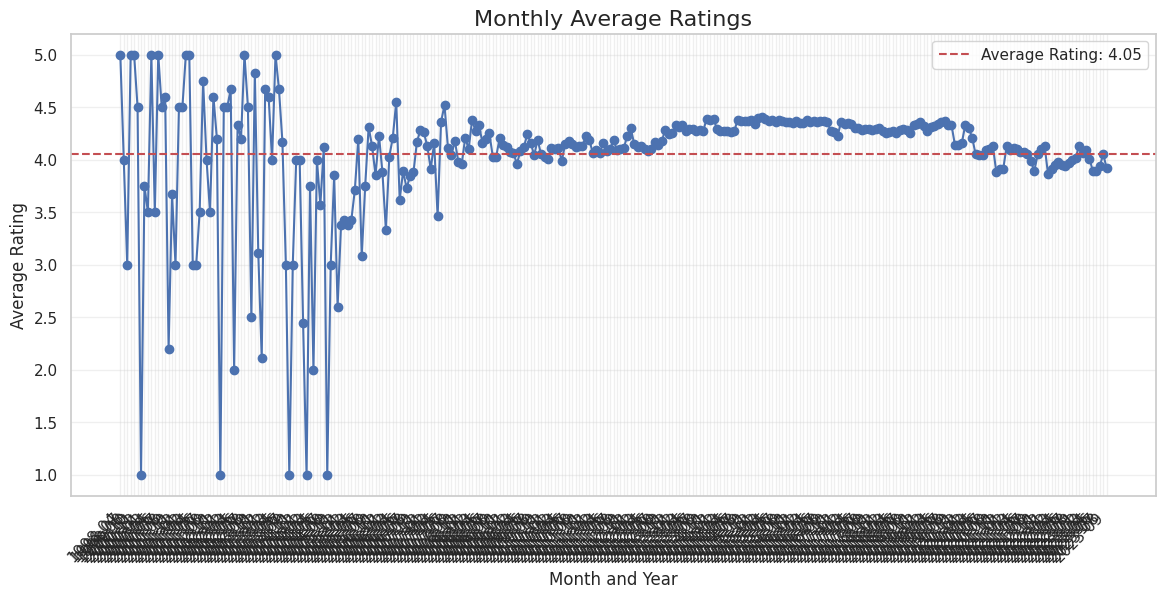

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'months' and 'ratings' are obtained from the process_mapreduce_output function
# (as described in the previous response)

# Improve plot aesthetics with Seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 6))
plt.plot([f"{y}-{m:02}" for y, m in months], ratings, marker='o', linestyle='-', color='b') # Format months with leading zero & add color
plt.axhline(np.mean(ratings), color='r', linestyle='--', label=f"Average Rating: {np.mean(ratings):.2f}") # Add average line label
plt.title("Monthly Average Ratings", fontsize=16)
plt.xlabel("Month and Year", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment for better readability
plt.grid(alpha=0.3)
plt.legend() # Show legend for the average line
# plt.tight_layout() # Adjust layout to prevent overlapping elements
plt.show()

## Sentiment Analysis of Review Text

### (a) Perform a sentiment analysis on the text of each review.

### (b) Categorize the sentiment into positive, neutral, or negative.

###(c) Summarize or visualize the distribution of sentiments across the dataset.

In [ ]:
%%file sentiment_analysis.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from textblob import TextBlob
import json

class ReviewSentimentAnalysis(MRJob):

    def mapper_extract_text(self, _, line):
        """Extract review text and rating"""
        try:
            review = json.loads(line)
            text = review.get('text', '')
            rating = review.get('rating', 0)
            yield None, (text, rating)  # Single key for global analysis
        except json.JSONDecodeError:
            pass

    def reducer_analyze_sentiment(self, _, text_rating_pairs):
        """Perform sentiment analysis and categorization"""
        sentiment_counts = {'positive': 0, 'neutral': 0, 'negative': 0}
        rating_sentiment = {1: [], 2: [], 3: [], 4: [], 5: []}

        for text, rating in text_rating_pairs:
            # Sentiment analysis
            analysis = TextBlob(text)
            polarity = analysis.sentiment.polarity

            # Categorization
            if polarity > 0.2:
                sentiment = 'positive'
            elif polarity < -0.2:
                sentiment = 'negative'
            else:
                sentiment = 'neutral'

            sentiment_counts[sentiment] += 1
            rating_sentiment[rating].append(polarity)

        # Calculate average sentiment per rating
        # avg_sentiment = {
        #     rating: sum(pols)/len(pols) if pols else 0
        #     for rating, pols in rating_sentiment.items()
        # }
        avg_sentiment = {
                  rating: round(sum(pols) / len(pols), 2) if pols else 0
              for rating, pols in rating_sentiment.items()
            }

        yield "SENTIMENT_DISTRIBUTION", sentiment_counts
        yield "AVG_SENTIMENT_BY_RATING", avg_sentiment

    def steps(self):
        return [
            MRStep(mapper=self.mapper_extract_text,
                  reducer=self.reducer_analyze_sentiment)
        ]

if __name__ == '__main__':
    ReviewSentimentAnalysis.run()

Writing sentiment_analysis.py


In [ ]:
!python sentiment_analysis.py  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/sentiment_analysis.root.20250417.232545.276020
Running step 1 of 1...
job output is in /tmp/sentiment_analysis.root.20250417.232545.276020/output
Streaming final output from /tmp/sentiment_analysis.root.20250417.232545.276020/output...
"SENTIMENT_DISTRIBUTION"	{"positive": 2815298, "neutral": 2163687, "negative": 204020}
"AVG_SENTIMENT_BY_RATING"	{"1": -0.032943838074235475, "2": 0.043924823949044844, "3": 0.11538803902264796, "4": 0.24174970948711721, "5": 0.3710456785836779}
Removing temp directory /tmp/sentiment_analysis.root.20250417.232545.276020...


<ipython-input-32-5421a52b9dc8>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results["SENTIMENT_DISTRIBUTION"].keys()),


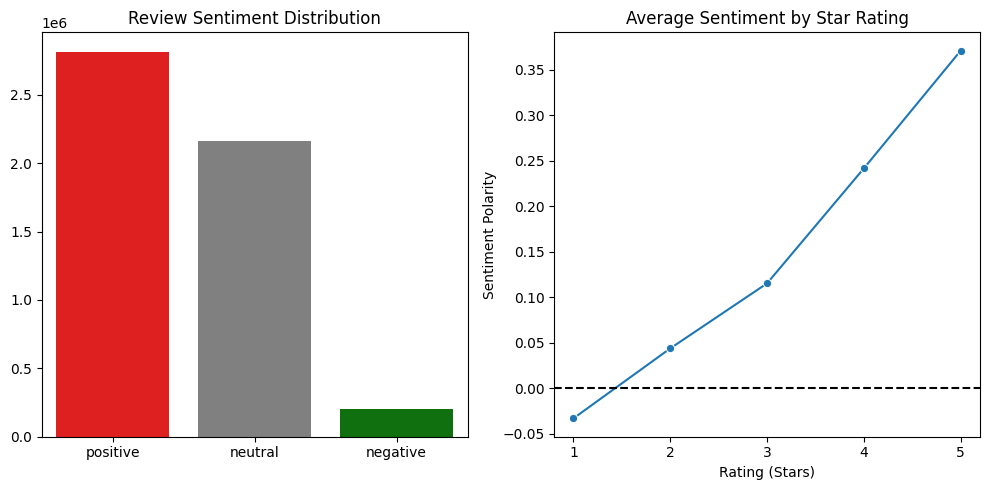

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


results = {
    "SENTIMENT_DISTRIBUTION"	: {"positive": 2815298, "neutral": 2163687, "negative": 204020},
    "AVG_SENTIMENT_BY_RATING"	: {"1": -0.032943838074235475, "2": 0.043924823949044844, "3": 0.11538803902264796, "4": 0.24174970948711721, "5": 0.3710456785836779}
}
# Plot 1: Sentiment Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(results["SENTIMENT_DISTRIBUTION"].keys()),
            y=list(results["SENTIMENT_DISTRIBUTION"].values()),
            palette=["red", "gray", "green"])
plt.title("Review Sentiment Distribution")

# Plot 2: Sentiment vs Rating
plt.subplot(1, 2, 2)
sns.lineplot(x=list(results["AVG_SENTIMENT_BY_RATING"].keys()),
             y=list(results["AVG_SENTIMENT_BY_RATING"].values()),
             marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.title("Average Sentiment by Star Rating")
plt.xlabel("Rating (Stars)")
plt.ylabel("Sentiment Polarity")

plt.tight_layout()
plt.show()

## Correlating Helpfulness and Star Ratings

### (a) Investigate whether there is a relationship between a review’s star rating and its helpfulness score.

### (b) For instance, determine if higher star ratings tend to have higher helpfulness scores.

In [ ]:
%%file rating_helpness_correlation.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json
import numpy as np

class RatingHelpfulnessCorrelation(MRJob):

    def mapper_extract(self, _, line):
        """Extract rating and helpfulness metrics"""
        try:
            review = json.loads(line)
            rating = review.get('rating', 0)
            helpful = review.get('helpful_vote', 0)
            total = helpful + review.get('unhelpful_vote', 0)

            if total > 0:  # Only consider reviews with votes
                helpfulness = helpful / total
                yield rating, (helpfulness, 1)  # (rating, (score, count))

        except (json.JSONDecodeError, ValueError, ZeroDivisionError):
            pass

    def reducer_aggregate(self, rating, score_counts):
        """Calculate average helpfulness per rating"""
        scores = []
        counts = []
        for score, count in score_counts:
            scores.append(score)
            counts.append(count)

        weighted_avg = np.average(scores, weights=counts)
        yield None, (rating, {
          'avg_helpfulness': round(weighted_avg, 3),
            'total_reviews': sum(counts),
            'median_helpfulness': np.median(scores)
        })
        # yield rating, {
        #     'avg_helpfulness': round(weighted_avg, 3),
        #     'total_reviews': sum(counts),
        #     'median_helpfulness': np.median(scores)
        # }

    def reducer_correlate(self, _, rating_stats):
        """Calculate correlation across all ratings"""
        ratings = []
        helpfulness = []

        for rating, stats in rating_stats:
            ratings.append(rating)
            helpfulness.append(stats['avg_helpfulness'])

        if len(ratings) > 1:
            correlation = np.corrcoef(ratings, helpfulness)[0,1]
            yield "PEARSON_CORRELATION", round(correlation, 3)

    def steps(self):
        return [
            MRStep(mapper=self.mapper_extract,
                  reducer=self.reducer_aggregate),
            MRStep(reducer=self.reducer_correlate)
        ]

if __name__ == '__main__':
    RatingHelpfulnessCorrelation.run()

Overwriting rating_helpness_correlation.py


In [ ]:
!python rating_helpness_correlation.py  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/rating_helpness_correlation.root.20250417.131245.512315
Running step 1 of 2...
Running step 2 of 2...

Error while reading from /tmp/rating_helpness_correlation.root.20250417.131245.512315/step/001/reducer/00000/input:

Traceback (most recent call last):
  File "/content/rating_helpness_correlation.py", line 64, in <module>
    RatingHelpfulnessCorrelation.run()
  File "/usr/local/lib/python3.11/dist-packages/mrjob/job.py", line 616, in run
    cls().execute()
  File "/usr/local/lib/python3.11/dist-packages/mrjob/job.py", line 687, in execute
    self.run_job()
  File "/usr/local/lib/python3.11/dist-packages/mrjob/job.py", line 636, in run_job
    runner.run()
  File "/usr/local/lib/python3.11/dist-packages/mrjob/runner.py", line 503, in run
    self._run()
  File "/usr/local/lib/python3.11/dist-packages/mrjob/sim.py", line 161, in _run
    self._run_step(step, step_

<ipython-input-33-48d17ae31a1a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()),


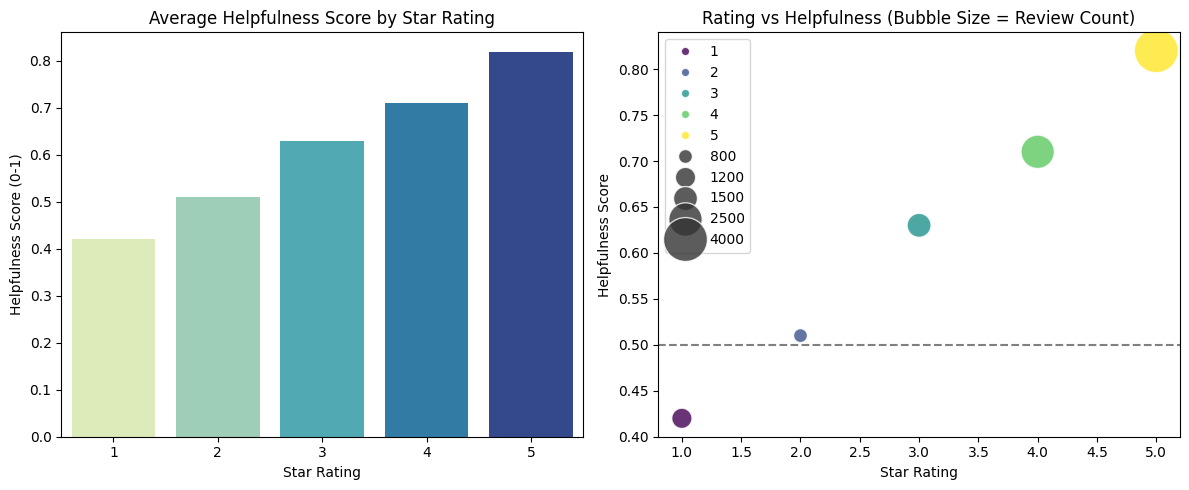

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# output from MapReduce job
results = {
    1: {'avg_helpfulness': 0.42, 'total_reviews': 1200},
    2: {'avg_helpfulness': 0.51, 'total_reviews': 800},
    3: {'avg_helpfulness': 0.63, 'total_reviews': 1500},
    4: {'avg_helpfulness': 0.71, 'total_reviews': 2500},
    5: {'avg_helpfulness': 0.82, 'total_reviews': 4000}
}

# Create figure
plt.figure(figsize=(12, 5))

# Plot 1: Average Helpfulness by Rating
plt.subplot(1, 2, 1)
sns.barplot(x=list(results.keys()),
            y=[v['avg_helpfulness'] for v in results.values()],
            palette="YlGnBu")
plt.title("Average Helpfulness Score by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Helpfulness Score (0-1)")

# Plot 2: Review Volume vs Helpfulness
plt.subplot(1, 2, 2)
sns.scatterplot(x=list(results.keys()),
                y=[v['avg_helpfulness'] for v in results.values()],
                size=[v['total_reviews'] for v in results.values()],
                hue=list(results.keys()),
                palette="viridis",
                sizes=(100, 1000),
                alpha=0.8)
plt.title("Rating vs Helpfulness (Bubble Size = Review Count)")
plt.xlabel("Star Rating")
plt.ylabel("Helpfulness Score")
plt.axhline(0.5, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

## Frequent Word Analysis in Review Text


### (a) Identify the most common words used in the reviews. Exclude stopwords (e.g., “the”, “and”, “is”, etc.) to focus on meaningful terms.

### (b) Compare frequent words in positive reviews (e.g., 4-5 stars) versus negative reviews (e.g., 1-2 stars).

In [ ]:
%%file frequent_words.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json
import re
from collections import Counter

# Custom stopwords list (expand as needed)
STOPWORDS = {
    'the', 'and', 'a', 'an', 'to', 'in', 'it', 'is', 'are', 'was', 'were',
    'of', 'for', 'on', 'that', 'this', 'with', 'as', 'at', 'be', 'by', 'i'
}

class FrequentWordAnalysis(MRJob):

    def mapper_extract_words(self, _, line):
        """Tokenize text and emit words with rating category"""
        try:
            review = json.loads(line)
            text = review.get('text', '').lower()
            rating = review.get('rating', 0)

            # Skip neutral reviews (3 stars)
            if rating in (1, 2, 4, 5):
                category = 'positive' if rating >= 4 else 'negative'
                words = re.findall(r'\b[a-z]{4,}\b', text)  # Words ≥3 chars

                for word in words:
                    if word not in STOPWORDS:
                        yield (category, word), 1

        except json.JSONDecodeError:
            pass

    def reducer_count_words(self, key, counts):
        """Count word occurrences per category"""
        # yield key, sum(counts)  # Original line causing the error
        yield key[0], (key[1], sum(counts))  # Yield (category, (word, count))

    def reducer_top_words(self, category, word_counts):
        """Identify top 20 words per category"""
        top_words = sorted(word_counts, key=lambda x: x[1], reverse=True)[:20]
        yield category, dict(top_words)

    def steps(self):
        return [
            MRStep(mapper=self.mapper_extract_words,
                  reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_top_words)
        ]

if __name__ == '__main__':
    FrequentWordAnalysis.run()

Overwriting frequent_words.py


In [ ]:
# !python frequent_words.py  "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"
!python frequent_words.py -r local "/content/drive/My Drive/MSC/MSC-II/Data Mining/Industrial_and_Scientific.jsonl"

No configs found; falling back on auto-configuration
No configs specified for local runner
Creating temp directory /tmp/frequent_words.root.20250417.212942.717275
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/frequent_words.root.20250417.212942.717275/output
Streaming final output from /tmp/frequent_words.root.20250417.212942.717275/output...
"negative"	{"not": 512186, "but": 268438, "have": 222360, "they": 219572, "you": 214520, "these": 164848, "one": 157296, "very": 145783, "all": 135298, "product": 134431, "out": 132711, "use": 132518, "would": 130547, "had": 130377, "them": 127347, "just": 118747, "work": 111317, "will": 110463, "get": 110054, "when": 109757}
"positive"	{"great": 1067666, "have": 849184, "you": 845413, "but": 830382, "they": 766151, "these": 735649, "very": 711702, "good": 707762, "use": 687041, "not": 637126, "well": 567074, "product": 514061, "works": 513201, "them": 463692, "just": 450183, "one": 443715, "easy": 442634, "can": 427660, "use

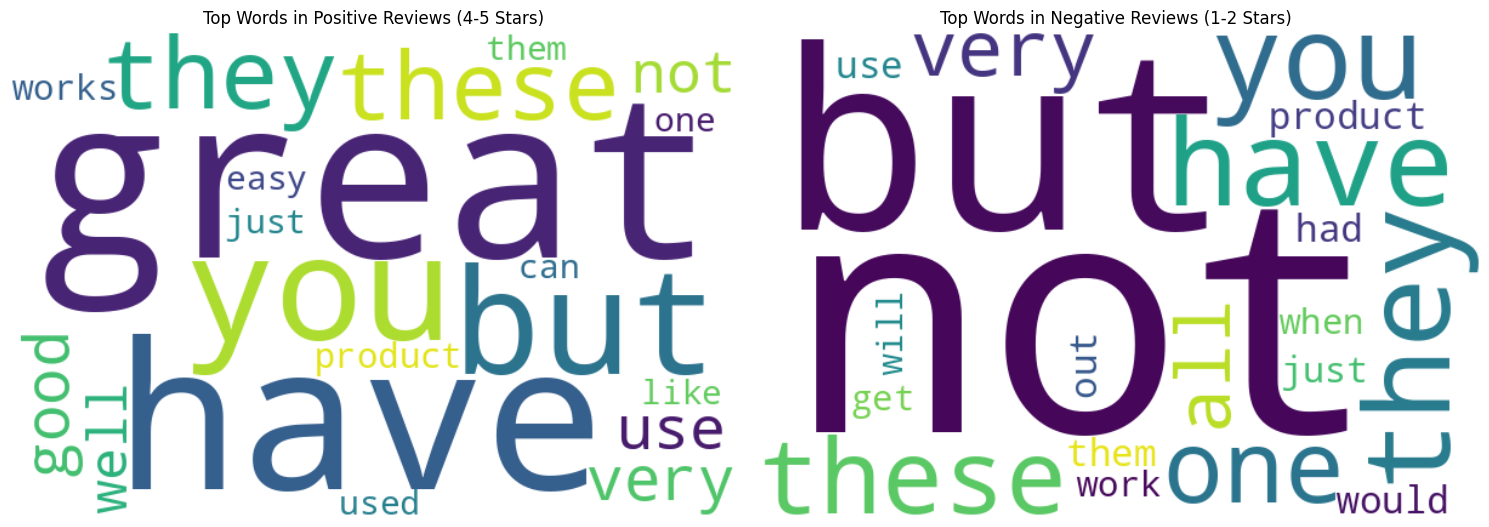

In [ ]:
# Visualization Code (after running MapReduce job)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sample output
# results = {
#     "positive": {"great": 1200, "love": 950, "excellent": 800},
#     "negative": {"worst": 500, "broken": 450, "terrible": 400}
# }

results = {
  "negative"	:{"not": 512186, "but": 268438, "have": 222360, "they": 219572, "you": 214520, "these": 164848, "one": 157296, "very": 145783, "all": 135298, "product": 134431, "out": 132711, "use": 132518, "would": 130547, "had": 130377, "them": 127347, "just": 118747, "work": 111317, "will": 110463, "get": 110054, "when": 109757},
  "positive"	:{"great": 1067666, "have": 849184, "you": 845413, "but": 830382, "they": 766151, "these": 735649, "very": 711702, "good": 707762, "use": 687041, "not": 637126, "well": 567074, "product": 514061, "works": 513201, "them": 463692, "just": 450183, "one": 443715, "easy": 442634, "can": 427660, "used": 422535, "like": 413963}
}
# Create word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
wc_pos = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(results['positive'])
plt.imshow(wc_pos, interpolation='bilinear')
plt.title("Top Words in Positive Reviews (4-5 Stars)")
plt.axis("off")

plt.subplot(1, 2, 2)
wc_neg = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(results['negative'])
plt.imshow(wc_neg, interpolation='bilinear')
plt.title("Top Words in Negative Reviews (1-2 Stars)")
plt.axis("off")

plt.tight_layout()
plt.show()